This step can be used if you are working inside Google Colab/Kaggle kernels or want to install LightAutoML on your machine:

In [2]:
# Developers version with better logging and final model description
!pip install -U https://github.com/sberbank-ai-lab/LightAutoML/raw/fix/logging/LightAutoML-0.2.16.2-py3-none-any.whl

     |████████████████████████████████| 263 kB 5.1 MB/s eta 0:00:01
     |████████████████████████████████| 204 kB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 36.9 MB/s eta 0:00:01
     |████████████████████████████████| 424 kB 56.4 MB/s eta 0:00:01
     |████████████████████████████████| 232 kB 70.9 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 24.9 MB/s eta 0:00:01    |▎                               | 20 kB 12.7 MB/s eta 0:00:01
     |████████████████████████████████| 84 kB 2.5 MB/s  eta 0:00:01
     |████████████████████████████████| 90 kB 7.5 MB/s  eta 0:00:01
     |████████████████████████████████| 100 kB 7.6 MB/s eta 0:00:01
     |████████████████████████████████| 93 kB 1.6 MB/s  eta 0:00:01
     |████████████████████████████████| 121 kB 69.6 MB/s eta 0:00:01
     |████████████████████████████████| 94 kB 2.2 MB/s  eta 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=

# Step 0.1. Import libraries

Here we will import the libraries we use in this kernel:
- Standard python libraries for timing, working with OS etc.
- Essential python DS libraries like numpy, pandas, scikit-learn and torch (the last we will use in the next cell)
- LightAutoML modules: presets for AutoML, task and report generation module

In [3]:
# Standard python libraries
import os
import time

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
from scipy.stats import rankdata
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

# Everything for graphs
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Step 0.2. Constants

Here we setup the constants to use in the kernel:
- `N_THREADS` - number of vCPUs for LightAutoML model creation
- `N_FOLDS` - number of folds in LightAutoML inner CV
- `RANDOM_STATE` - random seed for better reproducibility
- `TEST_SIZE` - houldout data part size 
- `TIMEOUT` - limit in seconds for model to train
- `TARGET_NAME` - target column name in dataset

In [4]:
N_THREADS = 5
N_FOLDS = 7
RANDOM_STATE = 42
TEST_SIZE = 0.3
TIMEOUT = 6*3600
TARGET_NAME = 'loss'

CUTOFFS = [0, 3, 5, 7, 10, 13, 15, 20]

# Step 0.3. Imported models setup

For better reproducibility we fix numpy random seed with max number of threads for Torch (which usually try to use all the threads on server):

In [5]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

# Step 0.4. Data loading
Let's check the data we have:

In [6]:
%%time

train_data = pd.read_csv('../input/tabular-playground-series-aug-2021/train.csv')
train_data.head()

CPU times: user 4.92 s, sys: 407 ms, total: 5.32 s
Wall time: 7.09 s


,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f91,f92,f93,f94,f95,f96,f97,f98,f99,loss
0,0,-0.002350,59,0.766739,-1.350460,42.2727,16.68570,30.3599,1.267300,0.392007,...,-42.43990,26.854000,1.45751,0.696161,0.941764,1.828470,0.924090,2.29658,10.48980,15
1,1,0.784462,145,-0.463845,-0.530421,27324.9000,3.47545,160.4980,0.828007,3.735860,...,-184.13200,7.901370,1.70644,-0.494699,-2.058300,0.819184,0.439152,2.36470,1.14383,3
2,2,0.317816,19,-0.432571,-0.382644,1383.2600,19.71290,31.1026,-0.515354,34.430800,...,7.43721,37.218100,3.25339,0.337934,0.615037,2.216760,0.745268,1.69679,12.30550,6
3,3,0.210753,17,-0.616454,0.946362,-119.2530,4.08235,185.2570,1.383310,-47.521400,...,9.66778,0.626942,1.49425,0.517513,-10.222100,2.627310,0.617270,1.45645,10.02880,2
4,4,0.439671,20,0.968126,-0.092546,74.3020,12.30650,72.1860,-0.233964,24.399100,...,290.65700,15.604300,1.73557,-0.476668,1.390190,2.195740,0.826987,1.78485,7.07197,1


In [7]:
test_data = pd.read_csv('../input/tabular-playground-series-aug-2021/test.csv')
test_data.head()

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
0,250000,0.812665,15,-1.239120,-0.893251,295.5770,15.87120,23.04360,0.942256,29.898000,...,0.446389,-422.332,-1.44630,1.69075,1.059300,-3.010570,1.94664,0.529470,1.386950,8.78767
1,250001,0.190344,131,-0.501361,0.801921,64.8866,3.09703,344.80500,0.807194,38.421900,...,0.377179,10352.200,21.06270,1.84351,0.251895,4.440570,1.90309,0.248534,0.863881,11.79390
2,250002,0.919671,19,-0.057382,0.901419,11961.2000,16.39650,273.24000,-0.003300,37.940000,...,0.990140,3224.020,-2.25287,1.55100,-0.559157,17.838600,1.83385,0.931796,2.336870,9.05400
3,250003,0.860985,19,-0.549509,0.471799,7501.6000,2.80698,71.08170,0.792136,0.395235,...,1.396880,9689.760,14.77150,1.41390,0.329272,0.802437,2.23251,0.893348,1.359470,4.84833
4,250004,0.313229,89,0.588509,0.167705,2931.2600,4.34986,1.57187,1.118300,7.754630,...,0.862502,2693.350,44.18050,1.58020,-0.191021,26.253000,2.68238,0.361923,1.532800,3.70660


In [8]:
samp_sub = pd.read_csv('../input/tabular-playground-series-aug-2021/sample_submission.csv')
samp_sub.head()

,id,loss
0,250000,0
1,250001,0
2,250002,0
3,250003,0
4,250004,0


# Step 0.5. Data splitting for train-holdout
As we have only one file with target values, we can split it into 80%-20% for holdout usage:

In [9]:
%%time

tr_data, te_data = train_test_split(train_data, 
                                    test_size=TEST_SIZE, 
                                    stratify=train_data[TARGET_NAME], 
                                    random_state=RANDOM_STATE)
print('Data splitted. Parts sizes: tr_data = {}, te_data = {}'.format(tr_data.shape, te_data.shape))

Data splitted. Parts sizes: tr_data = (175000, 102), te_data = (75000, 102)
CPU times: user 459 ms, sys: 93 ms, total: 552 ms
Wall time: 555 ms


In [10]:
tr_data.head()

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f91,f92,f93,f94,f95,f96,f97,f98,f99,loss
136829,136829,0.447887,39,0.785112,0.573600,2318.2300,8.04764,73.1422,0.889213,-6.59949,...,9426.2900,30.7208,3.90797,0.668909,6.023130,1.92582,0.202340,2.60951,10.834400,10
170084,170084,0.751811,7,-0.275354,0.405899,-64.4563,1.46066,29.5587,0.916817,58.64470,...,207.1040,18.2488,1.44998,-0.351569,0.226358,2.15168,0.661420,1.15237,13.731700,4
60574,60574,0.681065,92,0.449222,-0.052766,3696.6200,6.90561,258.7640,0.820351,97.44360,...,-69.5353,18.9685,1.56363,-0.023726,10.009700,2.59097,0.869089,2.28943,0.991251,34
30975,30975,0.271741,54,-0.433931,-0.066029,4745.9300,9.17750,54.7268,1.392110,143.96100,...,7734.6400,32.4270,3.62890,0.663934,0.711281,3.72101,0.407538,1.26662,1.468020,19
232141,232141,0.086534,83,-0.645116,-0.049101,31605.9000,8.98350,149.7790,1.005370,-7.16422,...,5466.8600,10.2175,1.52658,0.254714,3.282460,2.48727,0.233198,1.48647,25.692400,1


In [11]:
tr_data[TARGET_NAME].value_counts().shape

(43,)

# =========== LightAutoML model building ===========

# LightAutoML model creation - TabularAutoML preset

In next the cell we are going to create LightAutoML model with `TabularAutoML` class - preset with default model structure like in the image below:

<img src="https://github.com/sberbank-ai-lab/LightAutoML/raw/master/imgs/tutorial_blackbox_pipeline.png" alt="TabularAutoML preset pipeline" style="width:85%;"/>

in just several lines. Let's discuss the params we can setup:
- `task` - the type of the ML task (the only **must have** parameter)
- `timeout` - time limit in seconds for model to train
- `cpu_limit` - vCPU count for model to use
- `reader_params` - parameter change for Reader object inside preset, which works on the first step of data preparation: automatic feature typization, preliminary almost-constant features, correct CV setup etc. For example, we setup `n_jobs` threads for typization algo, `cv` folds and `random_state` as inside CV seed.
- `general_params` - we use `use_algos` key to setup the model structure to work with (Linear and LGBM model on the first level and their weighted composition creation on the second). This setup is only to speedup the kernel, you can remove this `general_params` setup if you want the whole LightAutoML model to run.

**Important note**: `reader_params` key is one of the YAML config keys, which is used inside `TabularAutoML` preset. [More details](https://github.com/sberbank-ai-lab/LightAutoML/blob/master/lightautoml/automl/presets/tabular_config.yml) on its structure with explanation comments can be found on the link attached. Each key from this config can be modified with user settings during preset object initialization. To get more info about different parameters setting (for example, ML algos which can be used in `general_params->use_algos`) please take a look at our [article on TowardsDataScience](https://towardsdatascience.com/lightautoml-preset-usage-tutorial-2cce7da6f936).

## In the cell below we are going to calculate LightAutoML classifier models for binary targets based on real target and cutoff like "bigger than X"

In [12]:
%%time 

IMP_arr = []
OOF_preds = []
TEST_preds = []
OOF_preds_parts = []
TEST_preds_parts = []
for i in CUTOFFS:
    print('Start {}'.format(i))
    tr_data[TARGET_NAME + '_cl'] = (tr_data[TARGET_NAME] > i).astype(int)
    te_data[TARGET_NAME + '_cl'] = (te_data[TARGET_NAME] > i).astype(int)
    
    # =============================================================
    
    task = Task('binary', )

    roles = {'target': TARGET_NAME + '_cl',
             'drop': ['id', TARGET_NAME]
             }

    automl = TabularAutoML(task = task, 
                           timeout = TIMEOUT,
                           cpu_limit = N_THREADS,
                           reader_params = {'n_jobs': N_THREADS, 'cv': 3, 'random_state': RANDOM_STATE},
                           general_params = {'use_algos': [['lgb', 'cb']], 
                                             'return_all_predictions': True, # return all predictions from the layer before blender
                                             'weighted_blender_max_nonzero_coef': 0.0}, # no drop for algos during blending phase
                           verbose = 1 # Available values: 0,1,2,3 (from less detailed to more)
                          )

    oof_pred = automl.fit_predict(tr_data, roles = roles)
    IMP_arr.append(automl.get_feature_scores('fast').set_index('Feature')['Importance'].to_dict())
    te_pred = automl.predict(te_data)
    
    # =============================================================
    
    OOF_preds_parts.append(oof_pred.data)
    TEST_preds_parts.append(te_pred.data)

    oof_pred_weighted = np.dot(oof_pred.data, automl.blender.wts) # Create weighted OOF preds based on single algos and blender weights
    te_pred_weighted = np.dot(te_pred.data, automl.blender.wts) # Create weighted Holdout preds based on single algos and blender weights
    OOF_preds.append(oof_pred_weighted)
    TEST_preds.append(te_pred_weighted)
    
    # =============================================================
    
    print('Check scores {}...'.format(i))
    print('OOF score: {}'.format(roc_auc_score(tr_data[TARGET_NAME + '_cl'].values, oof_pred_weighted)))
    print('HOLDOUT score: {}'.format(roc_auc_score(te_data[TARGET_NAME + '_cl'].values, te_pred_weighted)))

Start 0
[log_lvl_1] Start automl preset with listed constraints:
[log_lvl_1] - time: 21600.00 seconds
[log_lvl_1] - cpus: 5 cores
[log_lvl_1] - memory: 16 gb

[log_lvl_1] Train data shape: (175000, 103)

[log_lvl_1] Layer 1 ...

[log_lvl_1] Layer 1 train process start. Time left 21553.68 secs
[log_lvl_1] Start fitting Selector_LightGBM ...
[log_lvl_1] Selector_LightGBM fitting and predicting completed
[log_lvl_1] Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
[log_lvl_1] Algo = Lvl_0_Pipe_0_Mod_0_LightGBM, score = 0.6615323515839797
[log_lvl_1] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
[log_lvl_1] Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...
[log_lvl_1] Algo = Lvl_0_Pipe_0_Mod_1_CatBoost, score = 0.6549848350128356
[log_lvl_1] Lvl_0_Pipe_0_Mod_1_CatBoost fitting and predicting completed
[log_lvl_1] Time left 21102.80 secs

[log_lvl_1] Blending: Optimization starts with equal weights and score 0.6669527756220054
[log_lvl_1] Blending, iter 0: score = 0.6670054931320549

In [13]:
# Drop unnecessary columns created in the cell above
tr_data.drop(columns = [TARGET_NAME + '_cl'], inplace = True)
te_data.drop(columns = [TARGET_NAME + '_cl'], inplace = True)

# It's time to check the feature importances for different target cutoffs

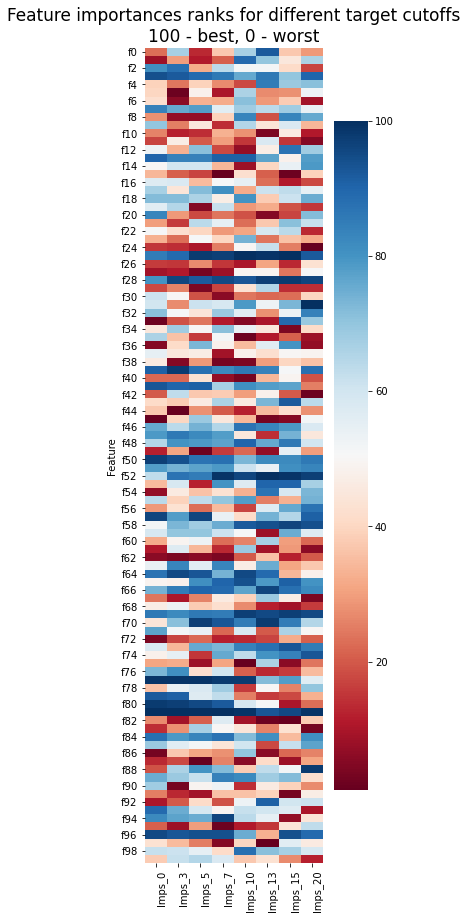

In [14]:
def feat_imp_plot(df, title):
    plt.figure(figsize=(4,15))
    ax = sns.heatmap(df.set_index('Feature'), 
                     annot=False, 
                     cmap="RdBu", 
                     annot_kws={"weight": "bold", "fontsize":13})
    ax.set_title(title, fontsize=17)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor", weight="normal")
    plt.setp(ax.get_yticklabels(), weight="normal",
             rotation_mode="anchor", rotation=0, ha="right")
    plt.show();

feats_imp_df = pd.DataFrame()
feats_imp_df['Feature'] = ['f'+str(i) for i in range(100)]
for cutoff, mapper in zip(CUTOFFS, IMP_arr):
    feats_imp_df['Imps_'+str(cutoff)] = rankdata(feats_imp_df['Feature'].map(mapper))

feat_imp_plot(feats_imp_df, "Feature importances ranks for different target cutoffs\n100 - best, 0 - worst")

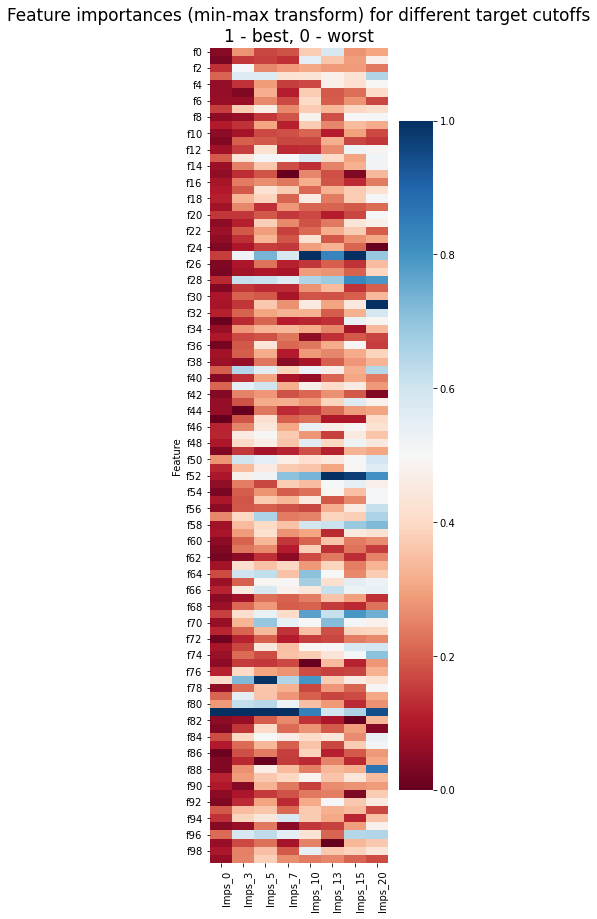

In [15]:
# Making a plot
Feats_imp_df = pd.DataFrame()
Feats_imp_df['Feature'] = ['f'+str(i) for i in range(100)]
for cutoff, mapper in zip(CUTOFFS, IMP_arr):
    Feats_imp_df['Imps_'+str(cutoff)] = Feats_imp_df['Feature'].map(mapper)
    mx, mn = Feats_imp_df['Imps_'+str(cutoff)].max(), Feats_imp_df['Imps_'+str(cutoff)].min()
    Feats_imp_df['Imps_'+str(cutoff)] = (Feats_imp_df['Imps_'+str(cutoff)] - mn) / (mx - mn)

feat_imp_plot(Feats_imp_df, "Feature importances (min-max transform) for different target cutoffs\n1 - best, 0 - worst")

### In both variants we see the known features in the top - `f81`, `f52` and `f25`.

### The work with classifiers predictions to create better features will be in the next versions   

In [ ]:
# oof_df = pd.DataFrame()
# oof_df[TARGET_NAME] = tr_data[TARGET_NAME]
# for cutoff, pred in zip(CUTOFFS, OOF_preds):
#     oof_df['Preds_'+str(cutoff)] = pred
    
# oof_df

In [ ]:
# te_df = pd.DataFrame()
# te_df[TARGET_NAME] = te_data[TARGET_NAME]
# for cutoff, pred in zip(CUTOFFS, TEST_preds):
#     te_df['Preds_'+str(cutoff)] = pred
    
# te_df

# Create new dataframes with classifiers predicts

In [16]:
def combine_preds_array_to_df(cutoffs_arr, preds_parts):
    preds_df = pd.DataFrame()
    prev_cutoff = None
    for cutoff, pred in zip(cutoffs_arr, preds_parts):
        preds_df['LGBM_'+str(cutoff)] = pred[:, 0]
        preds_df['CB_'+str(cutoff)] = pred[:, 1]
        
        if prev_cutoff is not None:
            preds_df['diff_LGBM_'+str(cutoff)] = preds_df['LGBM_'+str(prev_cutoff)] - preds_df['LGBM_'+str(cutoff)]
            preds_df['diff_CB_'+str(cutoff)] = preds_df['CB_'+str(prev_cutoff)] - preds_df['CB_'+str(cutoff)]
        prev_cutoff = cutoff
    
    return preds_df

tr_preds_df = combine_preds_array_to_df(CUTOFFS, OOF_preds_parts)
te_preds_df = combine_preds_array_to_df(CUTOFFS, TEST_preds_parts)
print(tr_preds_df.shape, te_preds_df.shape)

(175000, 30) (75000, 30)


In [17]:
tr_preds_df.head()

,LGBM_0,CB_0,LGBM_3,CB_3,diff_LGBM_3,diff_CB_3,LGBM_5,CB_5,diff_LGBM_5,diff_CB_5,...,diff_LGBM_13,diff_CB_13,LGBM_15,CB_15,diff_LGBM_15,diff_CB_15,LGBM_20,CB_20,diff_LGBM_20,diff_CB_20
0,0.807829,0.758230,0.538455,0.546451,0.269374,0.211779,0.394275,0.454341,0.144180,0.092110,...,0.102189,0.090421,0.140092,0.153177,0.016396,0.034938,0.056667,0.084739,0.083425,0.068437
1,0.813128,0.761817,0.601353,0.561106,0.211775,0.200711,0.434162,0.456838,0.167191,0.104267,...,0.128194,0.065001,0.169587,0.176387,-0.002831,0.055681,0.067777,0.100048,0.101810,0.076339
2,0.833294,0.784329,0.556816,0.573365,0.276478,0.210964,0.538883,0.442153,0.017933,0.131212,...,0.175114,0.097682,0.172863,0.162342,0.041190,0.029468,0.095788,0.100534,0.077074,0.061809
3,0.811320,0.781625,0.512488,0.524862,0.298833,0.256762,0.391624,0.401062,0.120864,0.123800,...,0.062463,0.090905,0.110051,0.138340,0.082782,0.029141,0.045904,0.073715,0.064147,0.064625
4,0.763641,0.701549,0.521787,0.456321,0.241854,0.245228,0.403845,0.357882,0.117942,0.098439,...,0.054610,0.056637,0.110840,0.114023,0.031552,0.038147,0.051366,0.065605,0.059474,0.048418


In [18]:
for col in tr_preds_df.columns:
    tr_data[col] = tr_preds_df[col].values
    te_data[col] = te_preds_df[col].values

In [19]:
tr_data.head()

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,diff_LGBM_13,diff_CB_13,LGBM_15,CB_15,diff_LGBM_15,diff_CB_15,LGBM_20,CB_20,diff_LGBM_20,diff_CB_20
136829,136829,0.447887,39,0.785112,0.573600,2318.2300,8.04764,73.1422,0.889213,-6.59949,...,0.102189,0.090421,0.140092,0.153177,0.016396,0.034938,0.056667,0.084739,0.083425,0.068437
170084,170084,0.751811,7,-0.275354,0.405899,-64.4563,1.46066,29.5587,0.916817,58.64470,...,0.128194,0.065001,0.169587,0.176387,-0.002831,0.055681,0.067777,0.100048,0.101810,0.076339
60574,60574,0.681065,92,0.449222,-0.052766,3696.6200,6.90561,258.7640,0.820351,97.44360,...,0.175114,0.097682,0.172863,0.162342,0.041190,0.029468,0.095788,0.100534,0.077074,0.061809
30975,30975,0.271741,54,-0.433931,-0.066029,4745.9300,9.17750,54.7268,1.392110,143.96100,...,0.062463,0.090905,0.110051,0.138340,0.082782,0.029141,0.045904,0.073715,0.064147,0.064625
232141,232141,0.086534,83,-0.645116,-0.049101,31605.9000,8.98350,149.7790,1.005370,-7.16422,...,0.054610,0.056637,0.110840,0.114023,0.031552,0.038147,0.051366,0.065605,0.059474,0.048418


# Comparing usual model with the model on extended dataset 

In [20]:
def rmse(y_true, y_pred, **kwargs):
    return mean_squared_error(y_true, y_pred, squared = False, **kwargs)

[log_lvl_1] Start automl preset with listed constraints:
[log_lvl_1] - time: 21600.00 seconds
[log_lvl_1] - cpus: 5 cores
[log_lvl_1] - memory: 16 gb

[log_lvl_1] Train data shape: (175000, 132)

[log_lvl_1] Layer 1 ...

[log_lvl_1] Layer 1 train process start. Time left 21583.07 secs
[log_lvl_1] Start fitting Selector_LightGBM ...
[log_lvl_1] Selector_LightGBM fitting and predicting completed
[log_lvl_1] Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
[log_lvl_1] Algo = Lvl_0_Pipe_0_Mod_0_LightGBM, score = -61.78750255465115
[log_lvl_1] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
[log_lvl_1] Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...
[log_lvl_1] Algo = Lvl_0_Pipe_0_Mod_1_CatBoost, score = -61.804401744105455
[log_lvl_1] Lvl_0_Pipe_0_Mod_1_CatBoost fitting and predicting completed
[log_lvl_1] Time left 20986.36 secs

[log_lvl_1] Blending: Optimization starts with equal weights and score -61.66685897540068
[log_lvl_1] Blending, iter 0: score = -61.66672071117234, weigh

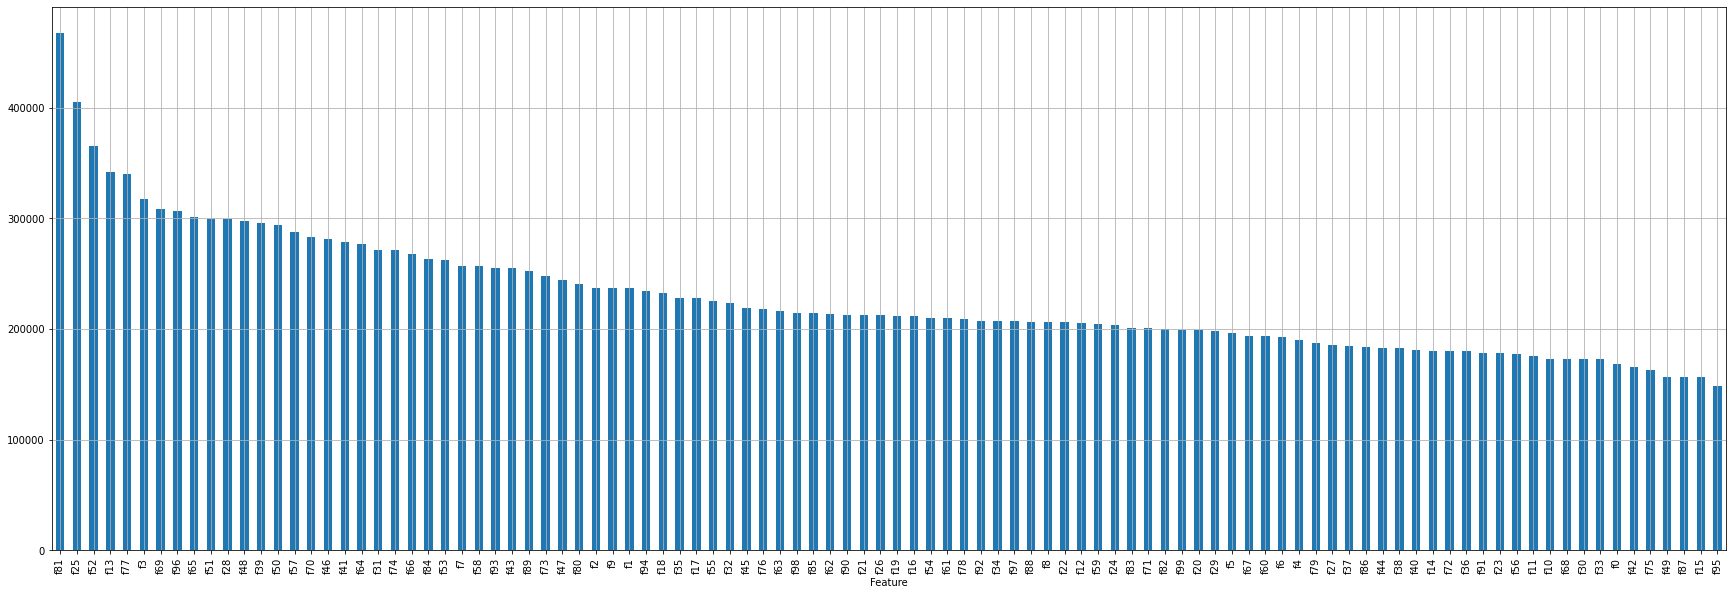

In [21]:
task = Task('reg', )

roles = {'target': TARGET_NAME,
         'drop': ['id'] + list(tr_preds_df.columns)
         }

automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                       general_params = {'use_algos': [['lgb', 'cb']]},
                       verbose = 1 # Available values: 0,1,2,3 (from less detailed to more)
                      )

oof_pred = automl.fit_predict(tr_data, roles = roles)
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)
te_pred = automl.predict(te_data)

print('Check scores...')
print('OOF score: {}'.format(rmse(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])))
print('HOLDOUT score: {}'.format(rmse(te_data[TARGET_NAME].values, te_pred.data[:, 0])))

[log_lvl_1] Start automl preset with listed constraints:
[log_lvl_1] - time: 21600.00 seconds
[log_lvl_1] - cpus: 5 cores
[log_lvl_1] - memory: 16 gb

[log_lvl_1] Train data shape: (175000, 132)

[log_lvl_1] Layer 1 ...

[log_lvl_1] Layer 1 train process start. Time left 21543.36 secs
[log_lvl_1] Start fitting Selector_LightGBM ...
[log_lvl_1] Selector_LightGBM fitting and predicting completed
[log_lvl_1] Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
[log_lvl_1] Algo = Lvl_0_Pipe_0_Mod_0_LightGBM, score = -61.511312910716214
[log_lvl_1] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
[log_lvl_1] Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...
[log_lvl_1] Algo = Lvl_0_Pipe_0_Mod_1_CatBoost, score = -61.495922573959085
[log_lvl_1] Lvl_0_Pipe_0_Mod_1_CatBoost fitting and predicting completed
[log_lvl_1] Time left 21262.38 secs

[log_lvl_1] Blending: Optimization starts with equal weights and score -61.4734358954221
[log_lvl_1] Blending, iter 0: score = -61.47294540209455, weigh

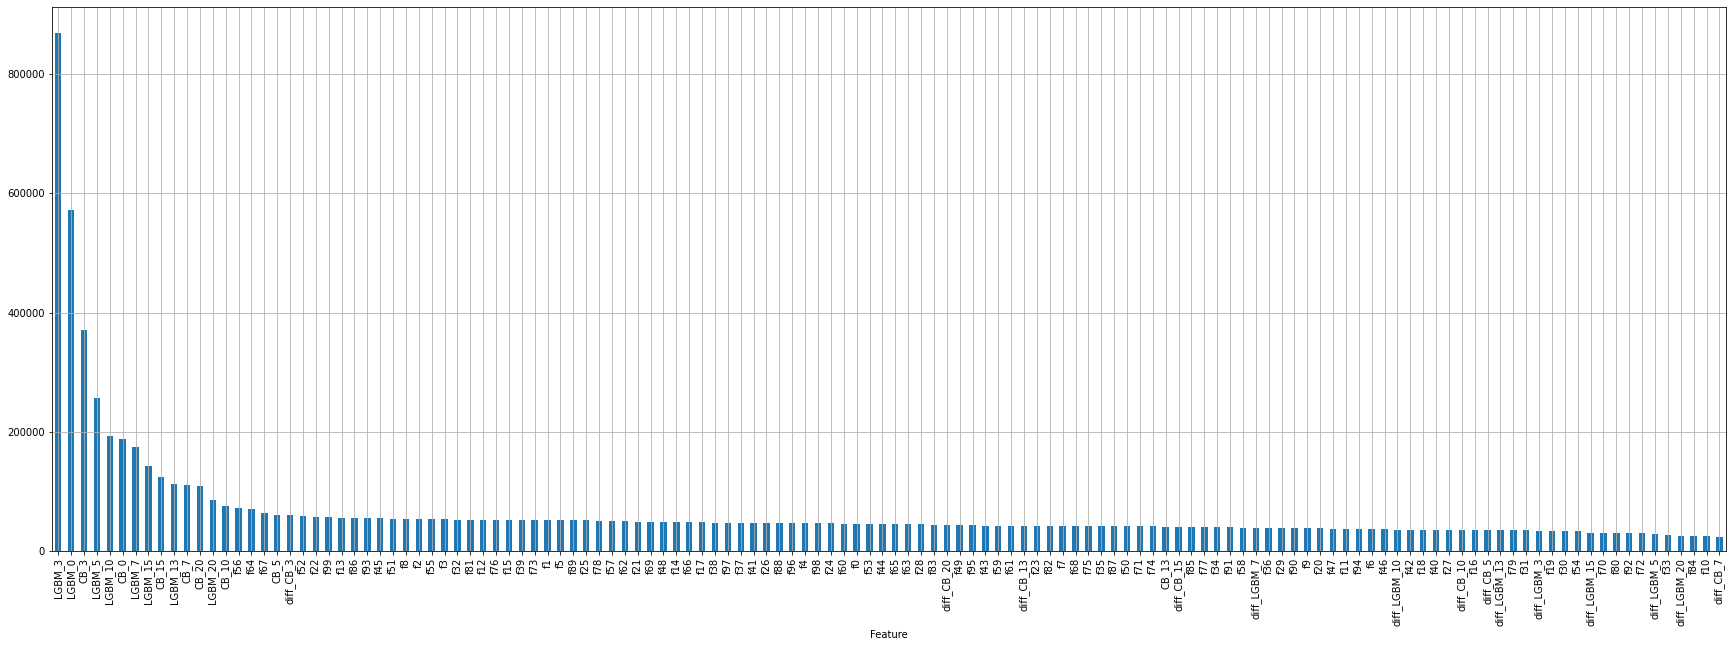

In [22]:
task = Task('reg', )

roles = {'target': TARGET_NAME,
         'drop': ['id']
         }

automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                       general_params = {'use_algos': [['lgb', 'cb']]},
                       verbose = 1 # Available values: 0,1,2,3 (from less detailed to more)
                      )

oof_pred = automl.fit_predict(tr_data, roles = roles)
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)
te_pred = automl.predict(te_data)

print('Check scores...')
print('OOF score: {}'.format(rmse(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])))
print('HOLDOUT score: {}'.format(rmse(te_data[TARGET_NAME].values, te_pred.data[:, 0])))

### Great - as we can see above the classifier predictions usage idea works fine and we can reproduce it on the full dataset

# Retrain on the full dataset

In [23]:
%%time 

OOF_preds = []
TEST_preds = []
OOF_preds_parts = []
TEST_preds_parts = []
for i in CUTOFFS:
    print('Start {}'.format(i))
    train_data[TARGET_NAME + '_cl'] = (train_data[TARGET_NAME] > i).astype(int)
    
    # =============================================================
    
    task = Task('binary', )

    roles = {'target': TARGET_NAME + '_cl',
             'drop': ['id', TARGET_NAME]
             }

    automl = TabularAutoML(task = task, 
                           timeout = TIMEOUT,
                           cpu_limit = N_THREADS,
                           reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                           general_params = {'use_algos': [['lgb', 'cb']], 
                                             'return_all_predictions': True, 
                                             'weighted_blender_max_nonzero_coef': 0.0},
                           verbose = 1 # Available values: 0,1,2,3 (from less detailed to more)
                          )

    oof_pred = automl.fit_predict(train_data, roles = roles)
    test_pred = automl.predict(test_data)
    
    # =============================================================
    
    OOF_preds_parts.append(oof_pred.data)
    TEST_preds_parts.append(test_pred.data)

    oof_pred_weighted = np.dot(oof_pred.data, automl.blender.wts)
    test_pred_weighted = np.dot(test_pred.data, automl.blender.wts)
    OOF_preds.append(oof_pred_weighted)
    TEST_preds.append(test_pred_weighted)
    
    # =============================================================
    
    print('Check scores {}...'.format(i))
    print('OOF score: {}'.format(roc_auc_score(train_data[TARGET_NAME + '_cl'].values, oof_pred_weighted)))

Start 0
[log_lvl_1] Start automl preset with listed constraints:
[log_lvl_1] - time: 21600.00 seconds
[log_lvl_1] - cpus: 5 cores
[log_lvl_1] - memory: 16 gb

[log_lvl_1] Train data shape: (250000, 103)

[log_lvl_1] Layer 1 ...

[log_lvl_1] Layer 1 train process start. Time left 21581.63 secs
[log_lvl_1] Start fitting Selector_LightGBM ...
[log_lvl_1] Selector_LightGBM fitting and predicting completed
[log_lvl_1] Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
[log_lvl_1] Algo = Lvl_0_Pipe_0_Mod_0_LightGBM, score = 0.6726634904218807
[log_lvl_1] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
[log_lvl_1] Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...
[log_lvl_1] Algo = Lvl_0_Pipe_0_Mod_1_CatBoost, score = 0.6641511352706732
[log_lvl_1] Lvl_0_Pipe_0_Mod_1_CatBoost fitting and predicting completed
[log_lvl_1] Time left 20026.60 secs

[log_lvl_1] Blending: Optimization starts with equal weights and score 0.676119289816161
[log_lvl_1] Blending, iter 0: score = 0.676365848371992, 

In [24]:
# Drop unnecessary columns created in the cell above
train_data.drop(columns = [TARGET_NAME + '_cl'], inplace = True)

In [25]:
def combine_preds_array_to_df(cutoffs_arr, preds_parts):
    preds_df = pd.DataFrame()
    prev_cutoff = None
    for cutoff, pred in zip(cutoffs_arr, preds_parts):
        preds_df['LGBM_'+str(cutoff)] = pred[:, 0]
        preds_df['CB_'+str(cutoff)] = pred[:, 1]
        preds_df['LGBM_CB_diff_'+str(cutoff)] = pred[:, 0] - pred[:, 1]
        if prev_cutoff is not None:
            preds_df['diff_LGBM_'+str(cutoff)] = preds_df['LGBM_'+str(prev_cutoff)] - preds_df['LGBM_'+str(cutoff)]
            preds_df['diff_CB_'+str(cutoff)] = preds_df['CB_'+str(prev_cutoff)] - preds_df['CB_'+str(cutoff)]
        prev_cutoff = cutoff
    
    return preds_df

train_preds_df = combine_preds_array_to_df(CUTOFFS, OOF_preds_parts)
test_preds_df = combine_preds_array_to_df(CUTOFFS, TEST_preds_parts)
print(train_preds_df.shape, test_preds_df.shape)

(250000, 38) (150000, 38)


In [26]:
for col in train_preds_df.columns:
    train_data[col] = train_preds_df[col].values
    test_data[col] = test_preds_df[col].values

### We need to append NN predictions as well to make better generalization 
#### Thanks for these predictions goes to @oxzplvifi and [his notebook](https://www.kaggle.com/oxzplvifi/tabular-denoising-residual-network) - do not forget to upvote it 👍

In [27]:
train_data['NN_preds'] = pd.read_csv('../input/tabular-denoising-residual-network/yoof.csv')[TARGET_NAME].values
test_data['NN_preds'] = pd.read_csv('../input/tabular-denoising-residual-network/submission.csv')[TARGET_NAME].values

# Now we are ready for training the model

In [28]:
lgb_params = {
    'metric': 'RMSE',
    'feature_pre_filter': False,
    'lambda_l1': 0.45,
    'lambda_l2': 4.8,
    'learning_rate': 0.005,
    'num_trees': 80000,
    'early_stopping_rounds': 200,
    'num_leaves': 10, 
    'feature_fraction': 0.4, 
    'bagging_fraction': 1.0, 
    'bagging_freq': 0, 
    'min_child_samples': 100,
    'num_threads': 5
}

cb_params = {
    'num_trees': 7000, 
    'od_wait': 600, 
    'learning_rate': 0.015, 
    'l2_leaf_reg': 64, 
    'subsample': 0.83, 
    'random_strength': 17.17, 
    'max_depth': 6, 
    'min_data_in_leaf': 10, 
    'leaf_estimation_iterations': 3,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'bootstrap_type': 'Bernoulli',
    'leaf_estimation_method': 'Newton',
    'random_seed': 42,
    "thread_count": 4
}

In [29]:
%%time 

CONF_PATH = '../input/lightautoml-configs/'

task = Task('reg', )

roles = {
    'target': TARGET_NAME,
    'drop': ['id']
}

automl = TabularUtilizedAutoML(task = task, 
                               timeout = TIMEOUT,
                               cpu_limit = N_THREADS,
                               reader_params = {'n_jobs': N_THREADS, 'cv': 10, 'random_state': RANDOM_STATE},
                               general_params = {'use_algos': [['lgb', 'cb']]}, # LGBM and CatBoost algos only
                               lgb_params = {'default_params': lgb_params, 'freeze_defaults': True}, # LGBM params
                               cb_params = {'default_params': cb_params, 'freeze_defaults': True}, # CatBoost params
                               verbose = 2, # Available values: 0,1,2,3 (from less detailed to more)
                               configs_list = [CONF_PATH + 'conf_0_sel_type_0.yml',
                                               CONF_PATH + 'conf_2_select_mode_1_no_typ.yml',
                                               CONF_PATH + 'conf_4_sel_type_0_no_int.yml',
                                               CONF_PATH + 'conf_6_sel_type_1_tuning_full_no_int_lgbm.yml'],
                               max_runs_per_config=1
                              )

oof_pred = automl.fit_predict(train_data, roles = roles)

[log_lvl_1] Config = conf_0_sel_type_0.yml, cur random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[log_lvl_1] Start automl preset with listed constraints:
[log_lvl_1] - time: 21600.00 seconds
[log_lvl_1] - cpus: 5 cores
[log_lvl_1] - memory: 16 gb

[log_lvl_1] Train data shape: (250000, 141)

[log_lvl_1] Layer 1 ...

[log_lvl_1] Layer 1 train process start. Time left 21539.52 secs
[log_lvl_1] Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
[log_lvl_2] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[log_lvl_2] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[log_lvl_2] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[log_lvl_2] ===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[log_lvl_2] ===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[log_lvl_2] ===== Start working with fold 5 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[log_lvl_

<AxesSubplot:xlabel='Feature'>

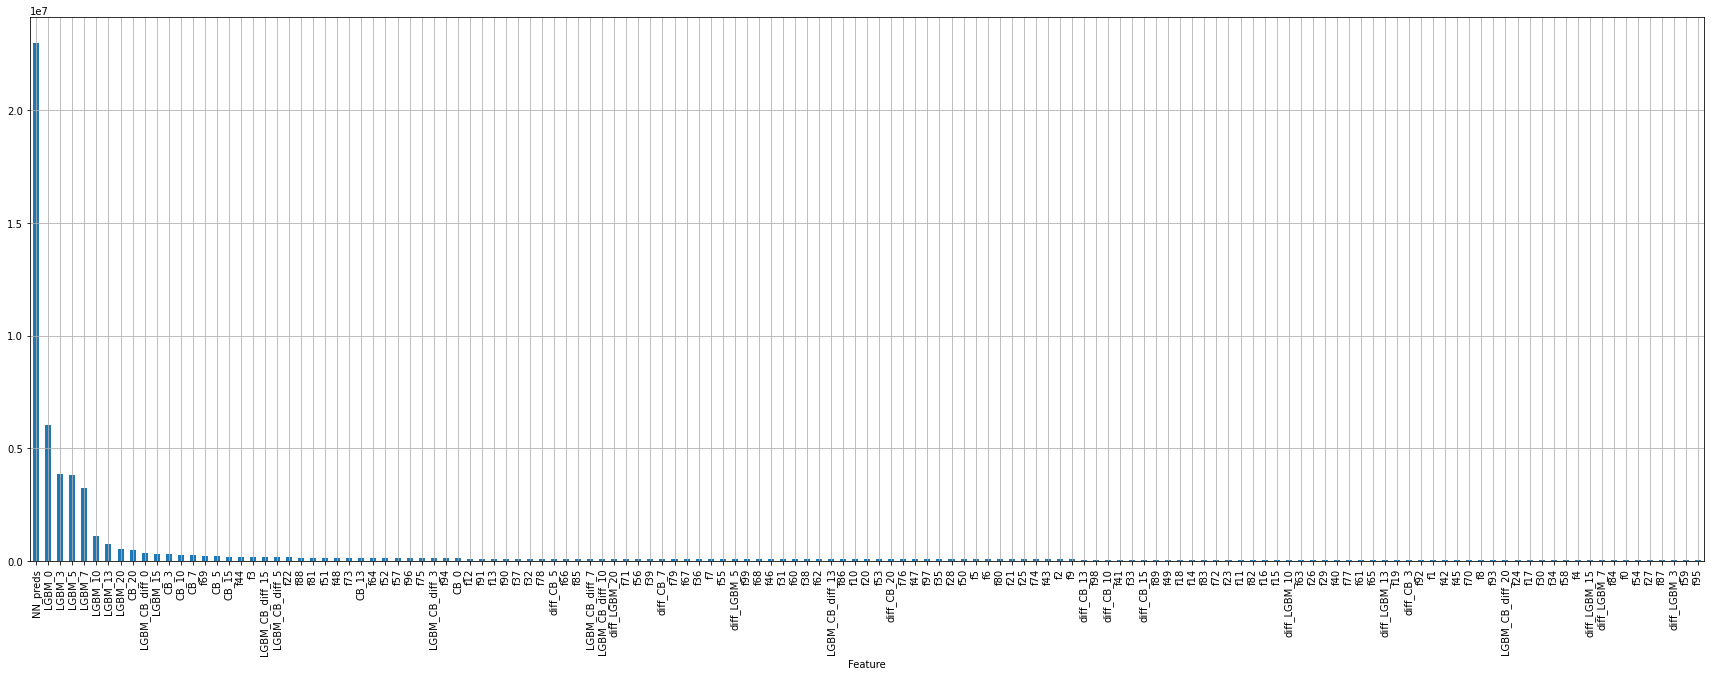

In [30]:
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

### Received model looks like 👇👇👇

In [32]:
print(automl.create_model_str_desc())

Final prediction for new objects = 
	0.38121 * 1 averaged models with config = "conf_0_sel_type_0.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.54446 * (10 averaged models Lvl_0_Pipe_0_Mod_0_LightGBM) +
			 0.45554 * (10 averaged models Lvl_0_Pipe_0_Mod_1_CatBoost) 


	+ 0.24635 * 1 averaged models with config = "conf_2_select_mode_1_no_typ.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.56821 * (10 averaged models Lvl_0_Pipe_0_Mod_0_LightGBM) +
			 0.43179 * (10 averaged models Lvl_0_Pipe_0_Mod_1_CatBoost) 


	+ 0.37244 * 1 averaged models with config = "conf_6_sel_type_1_tuning_full_no_int_lgbm.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.55225 * (10 averaged models Lvl_0_Pipe_0_Mod_0_LightGBM) +
			 0.44775 * (10 averaged models Lvl_0_Pipe_0_Mod_1_

# Predict for test data 

In [33]:
test_pred = automl.predict(test_data)
print('Prediction for test_data:\n{}\nShape = {}'.format(test_pred, test_pred.shape))

Prediction for test_data:
array([[7.972523 ],
       [4.822115 ],
       [8.767329 ],
       ...,
       [5.8144956],
       [5.0629563],
       [6.977707 ]], dtype=float32)
Shape = (150000, 1)


# Create submission file

In [34]:
samp_sub[TARGET_NAME] = test_pred.data[:, 0]
samp_sub.to_csv('LightAutoML_utilized_submission.csv', index = False)

In [35]:
samp_sub

,id,loss
0,250000,7.972523
1,250001,4.822115
2,250002,8.767329
3,250003,7.784342
4,250004,7.213951
...,...,...
149995,399995,8.125330
149996,399996,7.863353
149997,399997,5.814496
149998,399998,5.062956


## Upvote if you like the kernel or find it useful 👍

# Additional materials

- [Official LightAutoML github repo](https://github.com/sberbank-ai-lab/LightAutoML)
- [LightAutoML documentation](https://lightautoml.readthedocs.io/en/latest)
- [LightAutoML starter for TPS August 2021](https://www.kaggle.com/alexryzhkov/aug21-lightautoml-starter)